<a href="https://colab.research.google.com/github/hmaldonado12/7506R-1C2024-GRUPO6/blob/main/tp2/7506R_TP2_GRUPO06_ENTREGA_N2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras==2.12.0
!pip install tensorflow==2.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.12.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 35.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uni

# IMPORTS

In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import nltk

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_train_original = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
df_test_original = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')

df_train = df_train_original.copy()
df_test = df_test_original.copy()

# Preprocesamiento del dataset.

En esta notebook nos encargamos de efectuar la limpieza de dataset, la detección de datos incorrectos y/o vacíos, outliers, todo aquello que pueda imposibilitarnos a usar los modelos propuestos.

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           50000 non-null  int64 
 1   review_es    50000 non-null  object
 2   sentimiento  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


Podemos ver que el dataset train no tiene datos faltantes.

In [ ]:
df_train[df_train.duplicated(keep=False)]

,ID,review_es,sentimiento


Tampoco tiene filas duplicadas.

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599 entries, 0 to 8598
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         8599 non-null   int64 
 1   review_es  8599 non-null   object
dtypes: int64(1), object(1)
memory usage: 134.5+ KB


In [ ]:
df_test[df_test.duplicated(keep=False)]

,ID,review_es


El mismo resultado para test.

# Bag of words

Realizamos un procesamiento del texto, colocamos en mismo en lowercase, quitamos los signos de puntuación y eliminamos los stopweords para luego contar las apariciones de cada feature. Realizamos el procesamiento para el dataset de train, como para también de test para que el modelo pueda predecir.

In [ ]:
def preprocess_text(text):
    # tokenizacion
    tokens = word_tokenize(text.lower())
    # elimino signos de puntuación
    tokens = [word for word in tokens if word not in string.punctuation]
    # elimino stopwords
    stop_words = set(stopwords.words('spanish'))
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

df_train['review_es'] = df_train['review_es'].apply(preprocess_text)
df_test['review_es'] = df_test['review_es'].apply(preprocess_text)

In [ ]:
max_features_d = 8599
count_vect = CountVectorizer(min_df=5, max_features=max_features_d)

xtrain = count_vect.fit_transform(df_train['review_es'])
xtest = count_vect.transform(df_test['review_es'])

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(xtrain, df_train['sentimiento'], test_size=0.2, random_state=42)
X_test =xtest.copy()

Modifico el texto de Y_train e Y_val para que sean enteros.

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_val_encoded = label_encoder.transform(Y_val)

# TensorFlow + Keras


Utilizamos tensorflow con keras para hacer una red neuronal. Colocamos dos capas, una con 100 neuronas y otra, de salida, con solamente una para tener la predicción buscada

Sin buscar hiperparámetros con random search, obtuvimos buenos resultados haciendo pruebas y camibiando valores. Agregando más capas y más neuronas obteníamos un score peor, por ende nos quedamos solamente con dos.

In [ ]:
modelo = keras.Sequential([
    keras.layers.Dense(100,input_shape=(X_train.shape[1],)),
    keras.layers.Dense(1, activation='sigmoid')])

modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               860000    
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 860,101
Trainable params: 860,101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelo.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.001), #0.001
  loss='binary_crossentropy',
  # metricas para ir calculando en cada iteracion o batch
  metrics=['AUC'],
)

cant_epochs=100 #100
modelo_historia = modelo.fit(pd.DataFrame.sparse.from_spmatrix(X_train), np.ravel(Y_train_encoded),
                                                epochs=cant_epochs,
                                                batch_size=50,verbose=False)

In [ ]:
y_predic = modelo.predict(pd.DataFrame.sparse.from_spmatrix(X_val))
y_predic_cat = np.where(y_predic > 0.5, 1, 0)


313/313 [==============================] - 2s 5ms/step


In [ ]:
y_val_pred_labels = label_encoder.inverse_transform(y_predic_cat)
y_val_true_labels = label_encoder.inverse_transform(Y_val_encoded)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix

print("Accuracy:", accuracy_score(y_val_true_labels, y_val_pred_labels))
print("Precision:", precision_score(y_val_true_labels, y_val_pred_labels, pos_label='positivo'))
print("Recall:", recall_score(y_val_true_labels, y_val_pred_labels, pos_label='positivo'))
print("F1 Score:", f1_score(y_val_true_labels, y_val_pred_labels, pos_label='positivo'))

print("Classification Report:\n", classification_report(y_val_true_labels, y_val_pred_labels))

Accuracy: 0.8805
Precision: 0.8733488733488733
Recall: 0.8922405239134749
F1 Score: 0.8826936291351724
Classification Report:
               precision    recall  f1-score   support

    negativo       0.89      0.87      0.88      4961
    positivo       0.87      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



Se puede observar, entonces, que al realizar la predicción con el dataset de validación obtenemos buenos valores. Con un accuracy bastante alto. En la siguiente matriz de confusión también vemos que predica bastante bien las clases en comparanción a los otros modelos realizados.

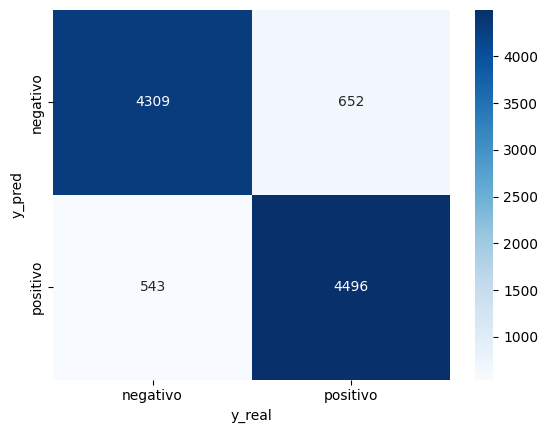

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

ds_validacion = pd.DataFrame(y_val_pred_labels,y_val_true_labels).reset_index()
ds_validacion.columns = ['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues',fmt='g')
plt.show()

Procedemos a realizar la predicción con test y guardar el resultado para subirlos a la competencia.

In [ ]:
y_predic_test = modelo.predict(pd.DataFrame.sparse.from_spmatrix(X_test))
y_predic_cat_test = np.where(y_predic_test > 0.5, 1, 0)

269/269 [==============================] - 3s 12ms/step


In [ ]:
y_val_pred_labels = label_encoder.inverse_transform(y_predic_cat_test)
y_val_pred_labels

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array(['negativo', 'positivo', 'negativo', ..., 'positivo', 'negativo',
       'negativo'], dtype=object)

In [ ]:
submit = pd.DataFrame({'ID': df_test['ID'], 'sentimiento': y_val_pred_labels})
submit

,ID,sentimiento
0,60000,negativo
1,60001,positivo
2,60002,negativo
3,60003,positivo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,positivo
8597,68597,negativo


In [ ]:
submit.to_csv('/content/drive/My Drive/Colab Notebooks/TensorFlow_v5.csv', index=False)

In [ ]:
submit

,ID,sentimiento
0,60000,negativo
1,60001,positivo
2,60002,negativo
3,60003,positivo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,positivo
8597,68597,negativo


# Búsqueda de hiperparámetros.

Siguiendo la misma arquitectura con dos capas, buscamos mejores hiperparámetros para intentar mejorar el score obtenido anteriormente. Consultando la bibliografía de keras utilizamos la biblioteca Keras Tuner para buscar los hiperparámetros.

Decidimos usar random search para minimizar los tiempos de ejecución. En esta ocación buscamos la cantidad más óptica de neuronas en la capa inicial (comenzando de 80 a 125) y el learning_rate.



In [ ]:
!pip install -q -U keras-tuner

In [ ]:
import keras_tuner as kt

In [ ]:
def model_builder(hp):
  model = keras.Sequential()

  hp_units = hp.Int('units', min_value=80, max_value=125, step=32)
  model.add(keras.layers.Dense(units=hp_units, input_shape=(X_train.shape[1],))),
  model.add(keras.layers.Dense(1, activation='sigmoid'))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(),
                metrics='accuracy')

  return model

In [ ]:
import keras_tuner as kt
from tensorflow import keras # Import keras here


tuner = kt.RandomSearch(
    hypermodel=model_builder,
    objective='val_accuracy',
    max_trials=10,
    seed=45,
)

Reloading Tuner from ./untitled_project/tuner0.json


In [ ]:
tuner.search(pd.DataFrame.sparse.from_spmatrix(X_train),Y_train_encoded, epochs=50, validation_split=0.2,batch_size=50)

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""units: {best_hps.get('units')}, learning rate: {best_hps.get('learning_rate')}.""")

units: 112, learning rate: 0.0001.


In [ ]:
unitsx = best_hps.get('units')
learningratex = best_hps.get('learning_rate')

Armamos nuevamente la red pero esta vez utilizando los hiperparámetros obtenidos anteriormente.

In [ ]:
modelo_2 = keras.Sequential([
    keras.layers.Dense(unitsx,input_shape=(X_train.shape[1],)),
    keras.layers.Dense(1, activation='sigmoid')])

modelo_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 112)               963200    
                                                                 
 dense_3 (Dense)             (None, 1)                 113       
                                                                 
Total params: 963,313
Trainable params: 963,313
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelo_2.compile(
  optimizer=keras.optimizers.SGD(learning_rate=learningratex), #0.001
  loss='binary_crossentropy',
  # metricas para ir calculando en cada iteracion o batch
  metrics=['accuracy'],
)

cant_epochs=50
modelo_2_historia = modelo_2.fit(pd.DataFrame.sparse.from_spmatrix(X_train), np.ravel(Y_train_encoded),
                                                epochs=cant_epochs,
                                                batch_size=50,verbose=False)

In [ ]:
y_predic = modelo_2.predict(pd.DataFrame.sparse.from_spmatrix(X_val))
y_predic_cat = np.where(y_predic > 0.5, 1, 0)

313/313 [==============================] - 2s 6ms/step


In [ ]:
y_val_pred_labels = label_encoder.inverse_transform(y_predic_cat)
y_val_true_labels = label_encoder.inverse_transform(Y_val_encoded)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix

print("Accuracy:", accuracy_score(y_val_true_labels, y_val_pred_labels))
print("Precision:", precision_score(y_val_true_labels, y_val_pred_labels, pos_label='positivo'))
print("Recall:", recall_score(y_val_true_labels, y_val_pred_labels, pos_label='positivo'))
print("F1 Score:", f1_score(y_val_true_labels, y_val_pred_labels, pos_label='positivo'))

print("Classification Report:\n", classification_report(y_val_true_labels, y_val_pred_labels))

Accuracy: 0.8037
Precision: 0.7986407766990291
Recall: 0.8162333796388173
F1 Score: 0.807341250368044
Classification Report:
               precision    recall  f1-score   support

    negativo       0.81      0.79      0.80      4961
    positivo       0.80      0.82      0.81      5039

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



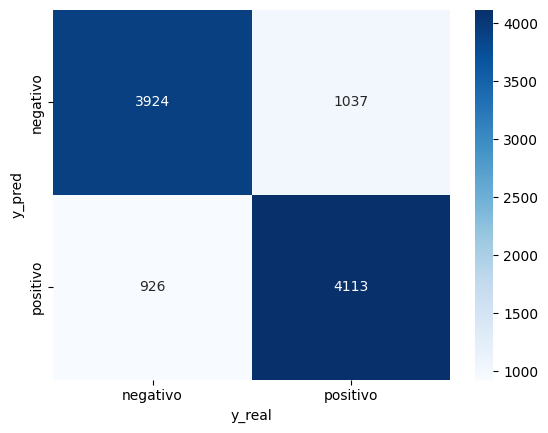

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

ds_validacion = pd.DataFrame(y_val_pred_labels,y_val_true_labels).reset_index()
ds_validacion.columns = ['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues',fmt='g')
plt.show()

Podemos notar que el score no resulta significablemente mayor al obtenido con el modelo anterior y se puede evidenciar también en el score obtenido en la competencia de Kaggle.

# Guardar modelo entrenado.

In [ ]:
import joblib
joblib.dump(modelo, '/content/drive/My Drive/Colab Notebooks/modelo_tensorflow_entrenado.pkl')

['/content/drive/My Drive/Colab Notebooks/modelo_tensorflow_entrenado.pkl']